# Diarization using WebRTC VAD

This notebook demonstrates how to use WebRTC's Voice Activity Detection (VAD) to perform diarization on an audio file. The VAD will help in identifying segments of speech in the audio.

## Step 1: Install Requirements

In [ ]:
# Setup installers
commands = [
    ("PIP_ROOT_USER_ACTION=ignore pip install -q webrtcvad", "Install webrtcvad"),
    ("PIP_ROOT_USER_ACTION=ignore pip install -q soundfile", "Install soundfile"),
    ("PIP_ROOT_USER_ACTION=ignore pip install -q numpy", "Install numpy"),
    ("PIP_ROOT_USER_ACTION=ignore pip install -q matplotlib", "Install matplotlib")
]

# Import the utils module which sets up the environment
from modules import utils
from modules import disable_warnings

# Use LogTools
log_tools = utils.LogTools()

# Execute
log_tools.command_state(commands)

## Step 2: Load Libraries & Helper Functions

In [ ]:
# Importing necessary libraries
import webrtcvad
import collections
import contextlib
import wave
import os
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

# Define a class to hold frame data
class Frame(object):
    def __init__(self, bytes, timestamp, duration):
        self.bytes = bytes
        self.timestamp = timestamp
        self.duration = duration

# Function to read a wave file
def read_wave(path):
    with contextlib.closing(wave.open(path, 'rb')) as wf:
        num_channels = wf.getnchannels()
        assert num_channels == 1
        sample_width = wf.getsampwidth()
        assert sample_width == 2
        sample_rate = wf.getframerate()
        assert sample_rate in (8000, 16000, 32000, 48000)
        pcm_data = wf.readframes(wf.getnframes())
        return pcm_data, sample_rate

# Function to generate frames from audio data
def frame_generator(frame_duration_ms, audio, sample_rate):
    n = int(sample_rate * (frame_duration_ms / 1000.0) * 2)
    offset = 0
    timestamp = 0.0
    duration = (float(n) / sample_rate) / 2.0
    while offset + n < len(audio):
        yield Frame(audio[offset:offset + n], timestamp, duration)
        timestamp += duration
        offset += n

# Function to collect voiced frames using VAD
def vad_collector(sample_rate, frame_duration_ms, padding_duration_ms, vad, frames):
    num_padding_frames = int(padding_duration_ms / frame_duration_ms)
    ring_buffer = collections.deque(maxlen=num_padding_frames)
    triggered = False

    voiced_frames = []
    for frame in frames:
        is_speech = vad.is_speech(frame.bytes, sample_rate)

        if not triggered:
            ring_buffer.append((frame, is_speech))
            num_voiced = len([f for f, s in ring_buffer if s])
            if num_voiced > 0.9 * ring_buffer.maxlen:
                triggered = True
                voiced_frames.extend(f for f, s in ring_buffer)
                ring_buffer.clear()
        else:
            voiced_frames.append(frame)
            ring_buffer.append((frame, is_speech))
            num_unvoiced = len([f for f, s in ring_buffer if not s])
            if num_unvoiced > 0.9 * ring_buffer.maxlen:
                triggered = False
                yield b''.join([f.bytes for f in voiced_frames])
                ring_buffer.clear()
                voiced_frames = []
    if voiced_frames:
        yield b''.join([f.bytes for f in voiced_frames])

## Step 3: Load the Audio File

We start by loading an audio file using `soundfile`. The audio needs to be in a format supported by `scipy`.

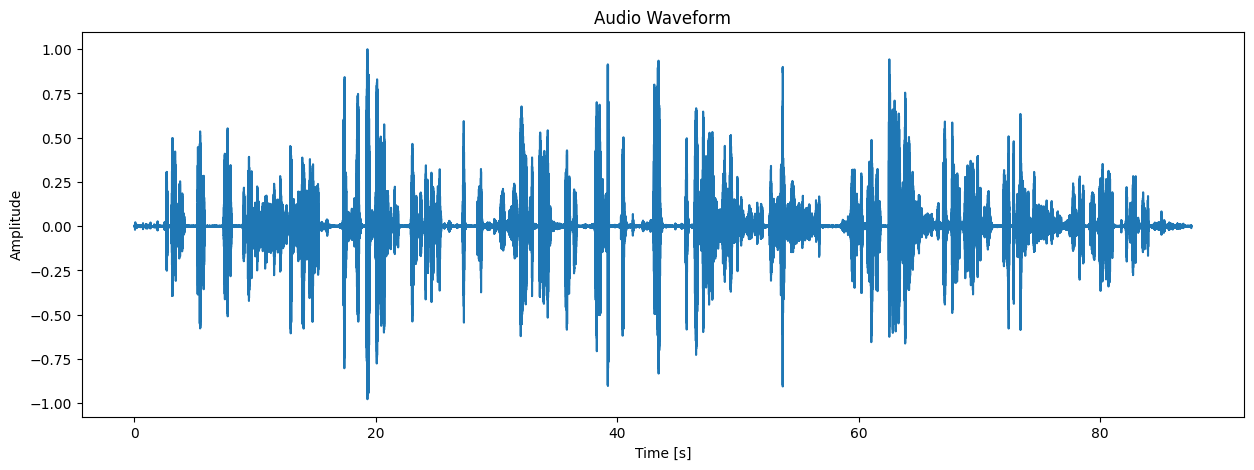

In [3]:
# Load audio file
audio_path = "../../test_pcm.wav"
audio, sample_rate = sf.read(audio_path)

# Plot the audio waveform
plt.figure(figsize=(15, 5))
plt.plot(np.linspace(0, len(audio) / sample_rate, num=len(audio)), audio)
plt.title('Audio Waveform')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

## Step 4: Process the Audio

We will process the audio file using WebRTC VAD.

In [4]:
# Initialize VAD
vad = webrtcvad.Vad(3)

# Generate frames and apply VAD
frames = frame_generator(30, audio, sample_rate)
frames = list(frames)
segments = vad_collector(sample_rate, 30, 300, vad, frames)

# Write segments to separate wave files
output_dir = "output_segments"
os.makedirs(output_dir, exist_ok=True)
for i, segment in enumerate(segments):
    segment_path = os.path.join(output_dir, f'chunk-{i:03d}.wav')
    with wave.open(segment_path, 'wb') as wf:
        wf.setnchannels(1)
        wf.setsampwidth(2)
        wf.setframerate(sample_rate)
        wf.writeframes(segment)
    print(f'Written {segment_path}')

Written output_segments/chunk-000.wav


## Step 5: Save & Compare Segments

We save the segmented audio to new files and inspect the results.

In [5]:
# Save the segmented audio                                                                                                                                 
output_dir = "output_segments"                                                                                                                             
os.makedirs(output_dir, exist_ok=True)                                                                                                                     
for i, segment in enumerate(segments):                                                                                                                     
    segment_path = os.path.join(output_dir, f'chunk-{i:03d}.wav')                                                                                          
    with wave.open(segment_path, 'wb') as wf:                                                                                                              
        wf.setnchannels(1)                                                                                                                                 
        wf.setsampwidth(2)                                                                                                                                 
        wf.setframerate(sample_rate)                                                                                                                       
        wf.writeframes(segment)                                                                                                                            
    print(f'Written {segment_path}')                                                                                                                       
                                                                                                                                                        
# Function to convert a matplotlib plot to a base64 encoded PNG image                                                                                      
def plt_to_base64(x, y, title):                                                                                                                            
    """Convert a matplotlib plot to a base64 encoded PNG image."""                                                                                         
    import io                                                                                                                                              
    import base64                                                                                                                                          
    plt.figure(figsize=(7, 5))                                                                                                                             
    plt.plot(x, y)                                                                                                                                         
    plt.title(title)                                                                                                                                       
    plt.xlabel('Time (s)')                                                                                                                                 
    plt.ylabel('Amplitude')                                                                                                                                
    buf = io.BytesIO()                                                                                                                                     
    plt.savefig(buf, format='png')                                                                                                                         
    buf.seek(0)                                                                                                                                            
    image_base64 = base64.b64encode(buf.read()).decode('utf-8')                                                                                            
    plt.close()                                                                                                                                            
    return image_base64                                                                                                                                    
                                                                                                                                                        
# Generate the waveforms for the original and segmented audio                                                                                              
time_original = np.linspace(0, len(audio) / sample_rate, num=len(audio))                                                                                   
time_segmented = np.linspace(0, len(segment) / sample_rate, num=len(segment))                                                                              
                                                                                                                                                        
# Create the HTML layout for plots and audio widgets side by side                                                                                          
html_content = f"""                                                                                                                                        
<div style="display: flex; justify-content: space-around; align-items: flex-start;">                                                                       
    <div>                                                                                                                                                  
        <h4>Original Audio</h4>                                                                                                                            
        <img src="data:image/png;base64,{plt_to_base64(time_original, audio, 'Original Audio')}" alt="Original Audio Waveform"/>                           
        <br>                                                                                                                                               
        {ipd.Audio(audio, rate=sample_rate)._repr_html_()}                                                                                                 
    </div>                                                                                                                                                 
    <div>                                                                                                                                                  
        <h4>Segmented Audio</h4>                                                                                                                           
        <img src="data:image/png;base64,{plt_to_base64(time_segmented, segment, 'Segmented Audio')}" alt="Segmented Audio Waveform"/>                      
        <br>                                                                                                                                               
        {ipd.Audio(segment, rate=sample_rate)._repr_html_()}                                                                                               
    </div>                                                                                                                                                 
</div>                                                                                                                                                     
"""                                                                                                                                                        
                                                                                                                                                        
# Display the HTML content                                                                                                                                 
display(HTML(html_content))                                  

NameError: name 'ipd' is not defined

## Conclusion

In this notebook, we demonstrated how to use WebRTC VAD to perform diarization on an audio file. The VAD helps in identifying segments of speech, which can then be processed further for various applications.

In [ ]:
import IPython.display as ipd
from IPython.display import display, HTML

# Function to convert a matplotlib plot to a base64 encoded PNG image
def plt_to_base64(x, y, title):
    """Convert a matplotlib plot to a base64 encoded PNG image."""
    import io
    import base64
    plt.figure(figsize=(7, 5))
    plt.plot(x, y)
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image_base64 = base64.b64encode(buf.read()).decode('utf-8')
    plt.close()
    return image_base64

# Generate the waveforms for the original and segmented audio
time_original = np.linspace(0, len(audio) / sample_rate, num=len(audio))
time_segmented = np.linspace(0, len(segment) / sample_rate, num=len(segment))

# Create the HTML layout for plots and audio widgets side by side
html_content = f"""
<div style="display: flex; justify-content: space-around; align-items: flex-start;">
    <div>
        <h4>Original Audio</h4>
        <img src="data:image/png;base64,{plt_to_base64(time_original, audio, 'Original Audio')}" alt="Original Audio Waveform"/>
        <br>
        {ipd.Audio(audio, rate=sample_rate)._repr_html_()}
    </div>
    <div>
        <h4>Segmented Audio</h4>
        <img src="data:image/png;base64,{plt_to_base64(time_segmented, segment, 'Segmented Audio')}" alt="Segmented Audio Waveform"/>
        <br>
        {ipd.Audio(segment, rate=sample_rate)._repr_html_()}
    </div>
</div>
"""

# Display the HTML content
display(HTML(html_content))